In [16]:
import json

from scipy.spatial import distance

with open("./data/coords.json", "r") as f:
    coords = json.loads(f.read())['coords']

print(len(coords))
#
# candidates = []
# while len(coords) > 0:
#     coord = coords[len(coords) - 1]
#     best = 1e9
#     if len(candidates) % 100 == 0:
#         print(len(candidates), len(coords))
#     for j, neighbour in enumerate(coords):
#         if coord[0] == neighbour[0] and coord[1] == neighbour[1]:
#             continue
#         d = distance.euclidean(coord, neighbour)
#         if d < best:
#             best = d
#     if best < 0.02:
#         candidates.append(coord)
#     coords.pop()
#
# print(len(coords))

1812


/tmp/ipykernel_145787/2624148386.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = algo.labels_.astype(np.int)


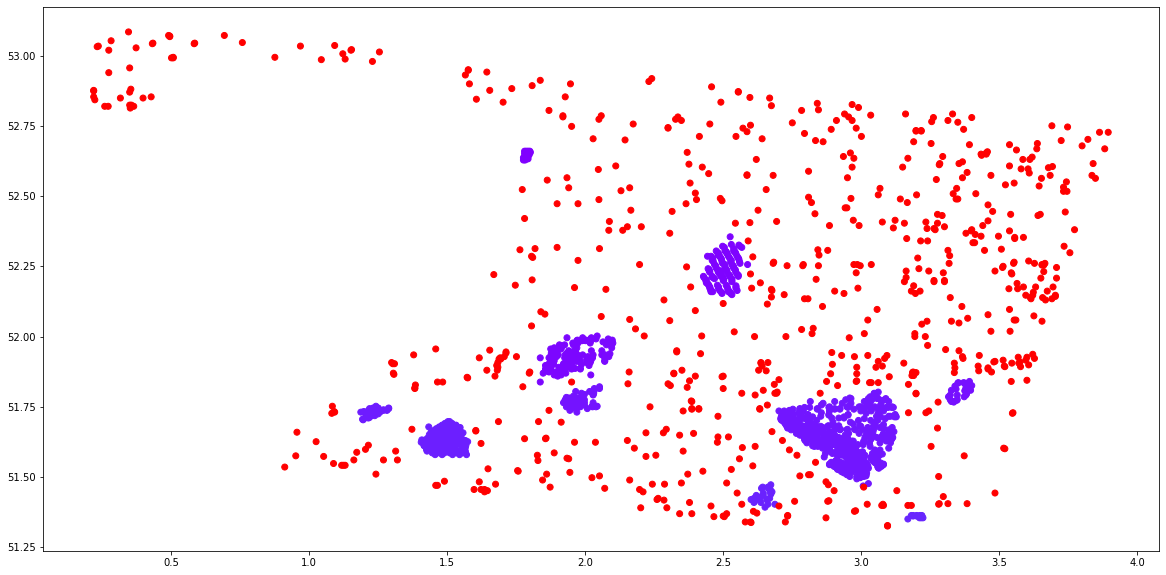

             X          Y  cluster
0     0.346406  53.085610       -1
1     0.491556  53.072988       -1
2     0.693504  53.072988       -1
3     0.495763  53.070884       -1
4     0.495763  53.068781       -1
...        ...        ...      ...
1807  2.599392  51.339598       -1
1808  2.725609  51.339598       -1
1809  2.601495  51.337495       -1
1810  3.095848  51.326977       -1
1811  3.095848  51.324873       -1

[1812 rows x 3 columns]


In [20]:
from sklearn import cluster
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

colors = np.array(['r', 'g', 'b', 'y', 'c', 't'])
colors = cm.rainbow(np.linspace(0, 1, 200))


def apply(X, algo):
    algo.fit(X)
    labels = algo.labels_.astype(np.int)
    plt.scatter(X[:, 0], X[:, 1], color=colors[labels])
    plt.show()
    return labels


df = pd.DataFrame(coords)
X = df.to_numpy()

# labels = apply(X, cluster.KMeans(n_clusters=8, max_iter=4000))


labels = apply(X, cluster.DBSCAN(eps=.035, min_samples=10))
# labels = apply(X, cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors"))

plt.rcParams["figure.figsize"] = [20, 10]
cluster_map = pd.DataFrame()
cluster_map['X'] = X[:, 0]
cluster_map['Y'] = X[:, 1]
cluster_map['cluster'] = labels

print(cluster_map)

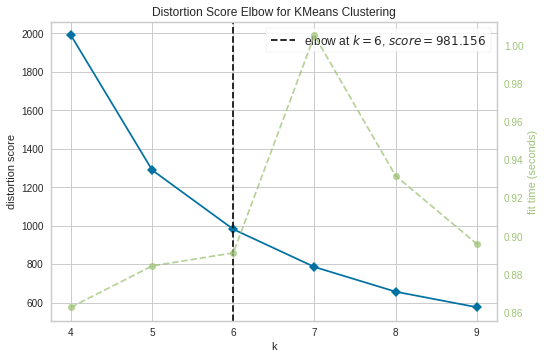

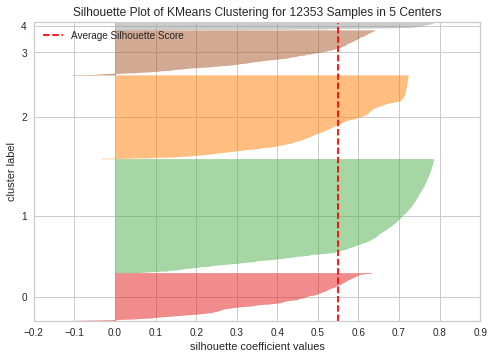

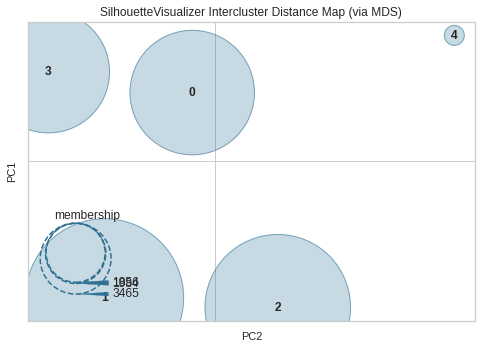

12353


In [19]:


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
# X, y = make_blobs(n_samples=1000, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

model = SilhouetteVisualizer(KMeans(5))
model.fit(X)
model.show()

from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(model)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

print(len(X))

In [ ]:
from shapely.geometry import LineString
import geopandas as gpd


def bounding_box(x_coordinates, y_coordinates):
    # x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]


list_lon = []
list_lat = []
list_geom = []

column_values = cluster_map["cluster"].values
clusters = np.unique(column_values)
bboxs = []
for cluster in clusters:
    if (cluster_map[cluster_map.cluster == cluster].shape[0] <= 20):
        continue
    bboxs.append(bounding_box(cluster_map[cluster_map.cluster == cluster]['X'],
                              cluster_map[cluster_map.cluster == cluster]['Y']))

l_lats = []
l_lons = []
boxes = []
for bbox in bboxs:
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[0][0])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[0][1])

    bb = gpd.points_from_xy(l_lats, l_lons, crs="EPSG:4326")

    boxes.append(LineString(bb))
    l_lats = []
    l_lons = []

df_result = gpd.GeoDataFrame({
    'geometry': boxes
})

df_result['geometry']
from shapely.ops import unary_union

cu = unary_union(df_result['geometry']);
df2_result = gpd.GeoDataFrame({
    'geometry': cu
})

df2_result.crs = 'epsg:4326'
df2_result.to_file("result.shp")